# 201601360 강준구
#### 이동통신사의 사용자 데이터를 분석해보겠습니다.  
#### 사용자의 가입기간, 데이터사용량, 요금 등 다양한 정보를 활용하여 회사 경영진에게 도움이 되는 데이터 분석 결과를 도출할 것입니다.
---

### 목표 :
#### 1. 중대한 매출을 제공하는 고객 데이터 분석
**매출의 상위 25% 고객 데이터 분석해서 못나가게 잡기 !** 

1. describe로 매출 상위 25%고객 분석 
 - 상위 10%, 하위 10%로 기준점을 설정했을 경우 값이 작아 분석하기 모호했습니다.
 - 이러한 이유로 좀더 러프한 결과값 도출을 위해 25%로 설정하였습니다.
2. 상위 25%고객의 데이터 사용량 등 분석 
---

#### 2. 블랙리스트 설정하기
1. describe로 매출 하위 25%고객 분석  
2. 하위 25%고객의 Callcenters 분석해서 3이상은 필요없는 고객으로 분류 이벤트 등에서 배제.
3. 매출도 안나오는 고객이 본사의 노동력을 자주 사용하는경우(콜센터에 전화) 경우 블랙리스트  
---
#### 3. 데이터를 범주하여 어느 컬럼이 월요금제와 가장 연관관계가 있는지 확인
1. 관계가 적은것거나 없는것은 서비스 차원으로 제공
2. 관계가 높은것은  금액을 올리거나 지속적인 홍보
---
#### 4. 이탈안하며 가입갱신을 한 충성 고객 분석
1. 이탈률 원인 분석 및 대체 방안 도출
1. 현재 고객이 상위 25% 고객이 될 수 있도록 다양한 서비스 제공가이드 제시
---
#### 5. 딥러닝 모델을 활용한 고객 이탈률 예측

# 분석전 결론 예상
#### 1. 상위 25%고객은 월요금제에 둔감하여 고객센터에 전화를 잘 안할것이다.
#### 2. 상위 25%고객이 월 매출의 절반이상을 차지할 것이다.
#### 3. 다른것에 비해 데이터를 많이 사용할수록 월요금이 증가할 것이다.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
telco=pd.read_csv('telco.csv')
telco

,Leave,MemberWeeks,NewContract,IsData,DataAmount,Callcenter,CalMins,CalCounts,MonthlyFee,OverFee,RoamingMin
0,0,128,1,1,2.70,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.70,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.00,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.00,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.00,3,166.7,113,41.0,7.42,10.1
...,...,...,...,...,...,...,...,...,...,...,...
3328,0,192,1,1,2.67,2,156.2,77,71.7,10.78,9.9
3329,0,68,1,0,0.34,3,231.1,57,56.4,7.67,9.6
3330,0,28,1,0,0.00,2,180.8,109,56.0,14.44,14.1
3331,0,184,0,0,0.00,2,213.8,105,50.0,7.98,5.0


**딕셔너리** 파일을 생성하여 불러왔습니다.

In [3]:
telco_dictionary=pd.read_csv('telco_dictionary.csv')
telco_dictionary

,columns,explain
0,Leave,가입해지여부(1이면 해지)
1,MemberWeeks,가입기간
2,NewContract,가입갱신여부(1이면 갱신)
3,IsData,데이터요금제사용여부(1이면 사용)
4,DataAmount,데이터사용량(GB)
5,Callcenter,고객센터전화량
6,CalMins,월평균전화량(분)
7,CalCounts,월평균전화수(횟수)
8,MonthlyFee,월평균요금
9,OverFee,초과요금


# 데이터 전처리

**info()** 를 통하여 Dtype과 memory usage를 확인해보겠습니다.  
현재 메모리는 286.6KB입니다.

In [4]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Leave        3333 non-null   int64  
 1   MemberWeeks  3333 non-null   int64  
 2   NewContract  3333 non-null   int64  
 3   IsData       3333 non-null   int64  
 4   DataAmount   3333 non-null   float64
 5   Callcenter   3333 non-null   int64  
 6   CalMins      3333 non-null   float64
 7   CalCounts    3333 non-null   int64  
 8   MonthlyFee   3333 non-null   float64
 9   OverFee      3333 non-null   float64
 10  RoamingMin   3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


다시한번 NULL값이 없음을 확인하였습니다.

In [5]:
telco.isna().sum()

Leave          0
MemberWeeks    0
NewContract    0
IsData         0
DataAmount     0
Callcenter     0
CalMins        0
CalCounts      0
MonthlyFee     0
OverFee        0
RoamingMin     0
dtype: int64

각각 적절한 Dtype으로 변경하여 줍니다.

In [6]:
telco['Leave']=telco['Leave'].astype('category')
telco['MemberWeeks']=telco['MemberWeeks'].astype('uint8')
telco['NewContract']=telco['NewContract'].astype('category')
telco['IsData']=telco['IsData'].astype('category')
telco['DataAmount']=telco['DataAmount'].astype('float16')
telco['Callcenter']=telco['Callcenter'].astype('uint8')
telco['CalMins']=telco['CalMins'].astype('float32')
telco['CalCounts']=telco['CalCounts'].astype('uint8')
telco['MonthlyFee']=telco['MonthlyFee'].astype('float32')
telco['OverFee']=telco['OverFee'].astype('float16')
telco['RoamingMin']=telco['RoamingMin'].astype('float16')

In [7]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Leave        3333 non-null   category
 1   MemberWeeks  3333 non-null   uint8   
 2   NewContract  3333 non-null   category
 3   IsData       3333 non-null   category
 4   DataAmount   3333 non-null   float16 
 5   Callcenter   3333 non-null   uint8   
 6   CalMins      3333 non-null   float32 
 7   CalCounts    3333 non-null   uint8   
 8   MonthlyFee   3333 non-null   float32 
 9   OverFee      3333 non-null   float16 
 10  RoamingMin   3333 non-null   float16 
dtypes: category(3), float16(3), float32(2), uint8(3)
memory usage: 65.5 KB


메모리가 22.8%로 절약되었습니다. 

In [8]:
print(65.5/286.6*100)

22.854152128401953


이탈 고객과 현재 고객 분리

In [9]:
Out_of_Member=telco[(telco.Leave==1)]
Current_Member=telco[(telco.Leave==0)]

In [10]:
Current_Member

,Leave,MemberWeeks,NewContract,IsData,DataAmount,Callcenter,CalMins,CalCounts,MonthlyFee,OverFee,RoamingMin
0,0,128,1,1,2.699219,1,265.100006,110,89.000000,9.867188,10.000000
1,0,107,1,1,3.699219,1,161.600006,123,82.000000,9.781250,13.703125
2,0,137,1,0,0.000000,0,243.399994,114,52.000000,6.058594,12.203125
3,0,84,0,0,0.000000,2,299.399994,71,57.000000,3.099609,6.601562
4,0,75,0,0,0.000000,3,166.699997,113,41.000000,7.421875,10.101562
...,...,...,...,...,...,...,...,...,...,...,...
3328,0,192,1,1,2.669922,2,156.199997,77,71.699997,10.781250,9.898438
3329,0,68,1,0,0.340088,3,231.100006,57,56.400002,7.671875,9.601562
3330,0,28,1,0,0.000000,2,180.800003,109,56.000000,14.437500,14.101562
3331,0,184,0,0,0.000000,2,213.800003,105,50.000000,7.980469,5.000000


In [11]:
telco.describe()

,MemberWeeks,DataAmount,Callcenter,CalMins,CalCounts,MonthlyFee,OverFee,RoamingMin
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,0.816895,1.562856,179.775131,100.435644,56.305111,10.054688,10.234375
std,39.822106,1.273438,1.315491,54.467442,20.069084,16.426031,2.535156,2.791016
min,1.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000
25%,74.000000,0.000000,1.000000,143.699997,87.000000,45.000000,8.328125,8.500000
50%,101.000000,0.000000,1.000000,179.399994,101.000000,53.500000,10.070312,10.296875
75%,127.000000,1.780273,2.000000,216.399994,114.000000,66.199997,11.773438,12.101562
max,243.000000,5.398438,9.000000,350.799988,165.000000,111.300003,18.187500,20.000000


In [12]:
Current_Member.describe()

,MemberWeeks,DataAmount,Callcenter,CalMins,CalCounts,MonthlyFee,OverFee,RoamingMin
count,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000
mean,100.793684,0.862305,1.449825,175.175903,100.283158,55.816246,9.953125,10.164062
std,39.882350,1.286133,1.163883,50.181633,19.801157,16.439007,2.515625,2.785156
min,1.000000,0.000000,0.000000,0.000000,0.000000,15.700000,0.000000,0.000000
25%,73.000000,0.000000,1.000000,142.825001,87.000000,45.000000,8.226562,8.398438
50%,100.000000,0.000000,1.000000,177.199997,100.000000,53.000000,9.976562,10.203125
75%,127.000000,2.000000,2.000000,210.300003,114.000000,64.674997,11.656250,12.000000
max,243.000000,4.750000,8.000000,315.600006,163.000000,111.300003,18.093750,18.906250


In [13]:
print(2850*55.816246)

159076.3011


# 본격 데이터 분석

In [14]:
(
    telco
    .groupby(['Leave'])
    [['MonthlyFee']]
    .agg(['sum','mean'])
    .style.highlight_max(axis=1)
)

# 1. 중대한 매출을 제공하는 고객 데이터 분석
## 매출의 상위 25% 고객 데이터 분석해서 못나가게 하는 가이드 제시!

#### 월 요금제 납부 금액 상위 25%와 하위 25% 분리하여 분석해보겠습니다.
**가입을 해지하지 않은 현재 고객을 기준**으로 매출 분석을 합니다.  
월 요금제를 많이 낸다고 해서 rich이거나 적게내서 poor은 아니지만 변수명은 해당이름으로 사용하겠습니다.

월 요금 하위 25%는 45달러 미만의 요금을 내며 상위 25%는 66달러 이상의 요금을 내고 있습니다.

In [15]:
telco['MonthlyFee'].describe()

count    3333.000000
mean       56.305111
std        16.426031
min        14.000000
25%        45.000000
50%        53.500000
75%        66.199997
max       111.300003
Name: MonthlyFee, dtype: float64

월 요금제 전체 요금은 159,076달러입니다.

In [16]:
print(2850*55.816246)

159076.3011


월 요금제를 많이 낸다고 해서 rich이거나 적게내서 poor은 아니지만 변수명은 해당이름으로 사용하겠습니다.

In [17]:
Rich_Customer=telco[(telco.MonthlyFee>=64.0)&(telco.Leave==0)]
Poor_Customer=telco[(telco.MonthlyFee<=45.0)&(telco.Leave==0)]

Rich Customer은 834명이 있습니다.

상위 25%의 고객은 평균 101.47달러의 요금을 매달 내고있으며 이들이 기여하는 전체 월 요금은 58,378 달러입니다.

In [18]:
Rich_Customer.describe()

,MemberWeeks,DataAmount,Callcenter,CalMins,CalCounts,MonthlyFee,OverFee,RoamingMin
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,101.472973,2.753906,1.459459,194.636185,99.817568,78.889214,10.453125,10.578125
std,39.247876,0.855469,1.230963,47.952339,19.859124,10.016573,2.455078,2.500000
min,1.000000,0.000000,0.000000,58.900002,35.000000,64.000000,3.259766,0.000000
25%,74.750000,2.320312,1.000000,160.100006,87.000000,70.300003,8.789062,8.898438
50%,101.000000,2.839844,1.000000,194.349998,100.000000,78.199997,10.523438,10.601562
75%,127.000000,3.289062,2.000000,225.500000,113.000000,85.624998,12.072266,12.203125
max,210.000000,4.750000,8.000000,315.600006,158.000000,111.300003,18.093750,17.593750


In [19]:
print(740*78.889214)

58378.018359999995


하위 25%의 고객은 평균 100.98달러의 요금을 매달 내고 있으며 이들의 전체 월 요금은 29447.99704달러입니다. 

In [20]:
Poor_Customer.describe()

,MemberWeeks,DataAmount,Callcenter,CalMins,CalCounts,MonthlyFee,OverFee,RoamingMin
count,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000
mean,100.989610,0.074524,1.340260,128.825790,101.068831,38.244152,8.890625,10.109375
std,40.317626,0.207031,0.998602,37.048634,20.153873,5.571832,2.445312,2.929688
min,1.000000,0.000000,0.000000,0.000000,0.000000,15.700000,0.000000,0.000000
25%,74.000000,0.000000,1.000000,106.099998,88.000000,35.000000,7.218750,8.398438
50%,99.500000,0.000000,1.000000,133.949997,100.000000,39.650000,8.914062,10.203125
75%,125.750000,0.000000,2.000000,154.374996,115.000000,42.599998,10.453125,12.000000
max,243.000000,2.320312,5.000000,227.399994,158.000000,45.000000,16.859375,18.906250


In [21]:
print(770*38.244152)

29447.99704


In [22]:
print(159076.3011-58378-29448)

71250.30110000001


### 상위 25%의 고객이 36.7%의 매출을 ,
### 하위 25%의 고객이 18.5%의 매출에 기여하고 있습니다.

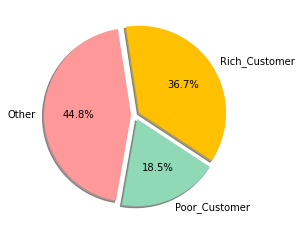

In [23]:
ratio = [71250.3,58378,29448]
labels = ['Other', 'Rich_Customer', 'Poor_Customer']
explode = [0.05, 0.05, 0.05]
colors = ['#ff9999', '#ffc000', '#8fd9b6']

plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, explode=explode, shadow=True, colors=colors)
plt.show()


## Rich_Customer 각각의 데이터들을 분석해 보겠습니다.

**Rich_Customer** 는 대부분 가입기간이 100주정도 됨을 알 수 있습니다.

<AxesSubplot:xlabel='MemberWeeks', ylabel='Density'>

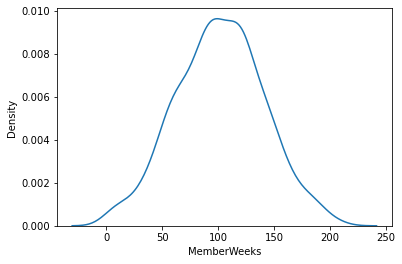

In [24]:
sns.kdeplot(Rich_Customer['MemberWeeks'])

1. 그래프를 확인하면 좌측 하단인 0 부근에도 어느정도 볼록히 올라와있습니다.  
즉, 데이터를 사용하지 않는 Rich Customer은 75명이 있습니다. 이분들은 통화를 많이 하나 봅니다. 

<AxesSubplot:xlabel='DataAmount', ylabel='Density'>

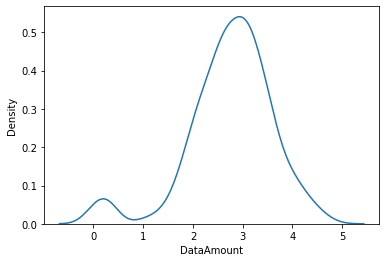

In [25]:
sns.kdeplot(Rich_Customer['DataAmount'])

2. 데이터를 사용하지않은 Rich Customer의 통화량을 분석해보겠습니다.

In [26]:
(Rich_Customer.DataAmount==0.0).value_counts()
NonData_Rich_Customer=Rich_Customer[(Rich_Customer.DataAmount==0.0)]

2-1. 데이터 사용하지 않는 Rich Customer의 **평균 통화량은 290분**입니다. 
**전체 사용자의 평균은 179분**에 비하면 **약 110분**을 한달에 더 통화를 하고 있습니다. 

In [27]:
telco['CalMins'].describe()

count    3333.000000
mean      179.775131
std        54.467442
min         0.000000
25%       143.699997
50%       179.399994
75%       216.399994
max       350.799988
Name: CalMins, dtype: float64

In [28]:
NonData_Rich_Customer['CalMins'].describe()

count     11.000000
mean     255.818176
std       19.816294
min      219.600006
25%      246.099998
50%      259.899994
75%      262.599991
max      293.000000
Name: CalMins, dtype: float64

3. 부자 고객의 월평균전화량(분) 
- 월 150~ 250분에 많이 몰려있음을 확인할 수 있습니다.

<AxesSubplot:xlabel='CalMins', ylabel='Density'>

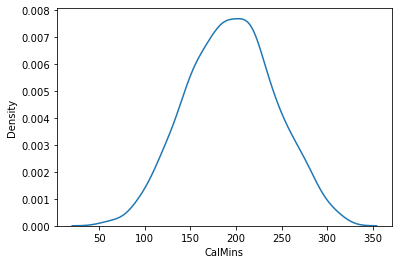

In [29]:
sns.kdeplot(Rich_Customer['CalMins'])

4. 부자 고객의 월평균전화 횟수
- 80~ 120회에 몰려있음을 확인할 수 있습니다.

<AxesSubplot:xlabel='CalCounts', ylabel='Density'>

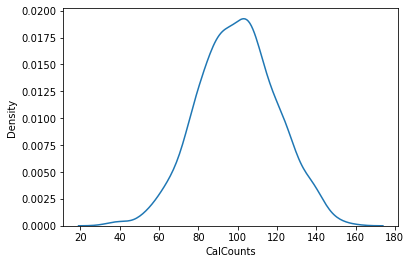

In [30]:
sns.kdeplot(Rich_Customer['CalCounts'])

그럼 이제 합리적인 의심이 안들 수 없습니다.

# Q. 부자 고객은 돈이 많으니 콜센터에 전화를 잘 안할까?
A. 확인해보니 평균 1.45회, 1.34회 정도로 **오히려 Rich_customer가 전화를 더 했습니다.**

In [31]:
Rich_Customer['Callcenter'].describe()

count    740.000000
mean       1.459459
std        1.230963
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        8.000000
Name: Callcenter, dtype: float64

In [32]:
Poor_Customer['Callcenter'].describe()

count    770.000000
mean       1.340260
std        0.998602
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: Callcenter, dtype: float64

In [33]:
import matplotlib.font_manager as fm
font_path = r'C:\Windows\Fonts\batang.ttc'
fontprop = fm.FontProperties(fname=font_path, size=18)

# 2. 블랙리스트 설정하기
고객한테는 죄송한 이야기 이지만 회사의 경영상 어쩔 수 없이 회사 운영에 피해를 주는 고객를 골라내야 합니다.  
매달 3회이상 콜센터에 전화하는 Poor Customer를 블랙리스트로 담아보겠습니다.

월 1회정도 콜센터에 전화하는 빈도수가 가장 많았습니다. 하지만 3회이상 통화하는것은 고객센터 업무에 과부하를 줄 수 있을 것 같습니다.

C:\Users\rkdwn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Poor Customer의 콜센터 전화 횟수')

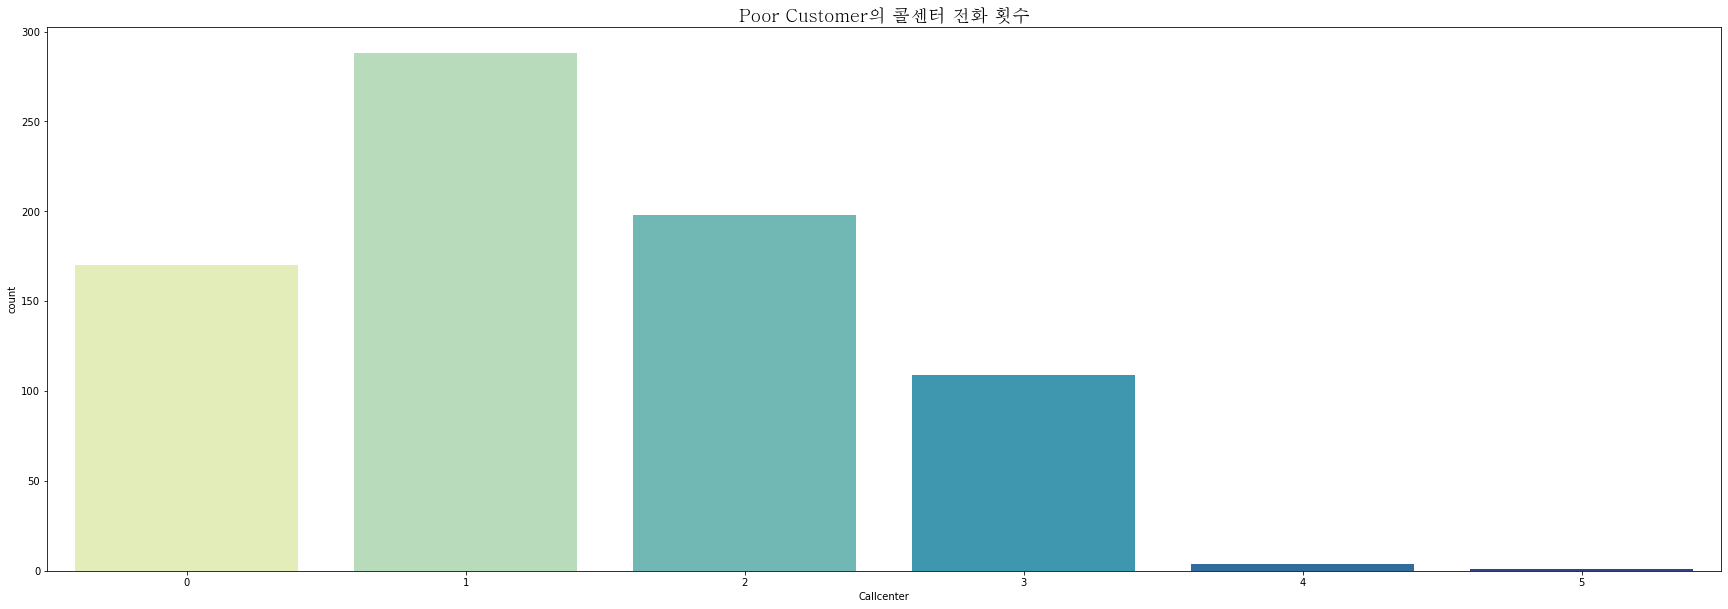

In [34]:
plt.rcParams['figure.figsize'] = (30, 10)
sns.countplot(Poor_Customer['Callcenter'], palette='YlGnBu')
ax = plt.gca()
ax.set_title("Poor Customer의 콜센터 전화 횟수",fontproperties=fontprop)

In [35]:
#Rich_Customer=telco[(telco.MonthlyFee>=66.2)]
Black_List=Poor_Customer[(Poor_Customer.Callcenter==3) | (Poor_Customer.Callcenter==4) | (Poor_Customer.Callcenter==5)|(Poor_Customer.Callcenter==6)|(Poor_Customer.Callcenter==7)|(Poor_Customer.Callcenter==8)|(Poor_Customer.Callcenter==9)]

## 블랙 리스트의 전체 요금을 확인해 봅니다.
블랙 리스트 : 월요금 하위 25%이면서 한달에 콜센터에 전화 3회 이상

블랙리스트는 전체 202명이며 평균 38.2 달러를 납부하고 있습니다.  
이들의 전체 요금은 7716.4 달러입니다.

In [36]:
Black_List['MonthlyFee'].describe()

count    114.000000
mean      38.224567
std        5.637698
min       20.000000
25%       35.000000
50%       39.850000
75%       42.000000
max       45.000000
Name: MonthlyFee, dtype: float64

In [37]:
print(114*38.2)

4354.8


블랙리스트의 매출은 전체의 2.7%정도이니 회사의 발전을 위하여 이정도는 감수해야겠습니다.  
이들에게 혜택등을 제공하지 않으면서 다른 업체로 넘어가도록 방치할 수 있습니다.

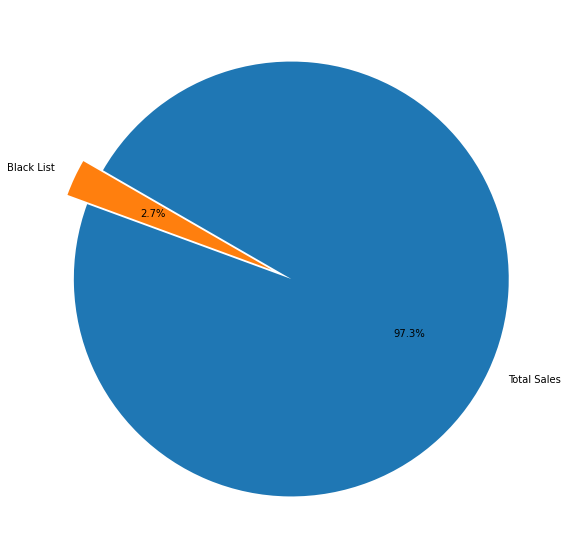

In [38]:
#ratio = [187664-7716.4,7716.4]
ratio=[159076.3011-4354.8,4354.8]
labels = ['Total Sales ','Black List']
explode = [0,0.10]

plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=150, counterclock=False, explode=explode)
plt.show()

# 3. 데이터를 범주화하여 어느 컬럼이 월요금제와 가장 연관관계가 있는지 확인  
관계가 적은것거나 없는것은 서비스 차원으로 제공  
관계가 높은것은 금액을 올리거나 지속적인 홍보  

# 3-1. 가입기간 범주화 
가입한 기간, 즉, 1년단위로 나누어 가입기간에 따른 매출은 어떻게 기여하고 바뀌는지 보도록 하겠습니다.

In [39]:
telco.MemberWeeks.describe()

count    3333.000000
mean      101.064806
std        39.822106
min         1.000000
25%        74.000000
50%       101.000000
75%       127.000000
max       243.000000
Name: MemberWeeks, dtype: float64

In [40]:
telco["Member_Year"]=0

In [41]:
telco.head()

,Leave,MemberWeeks,NewContract,IsData,DataAmount,Callcenter,CalMins,CalCounts,MonthlyFee,OverFee,RoamingMin,Member_Year
0,0,128,1,1,2.699219,1,265.100006,110,89.0,9.867188,10.000000,0
1,0,107,1,1,3.699219,1,161.600006,123,82.0,9.781250,13.703125,0
2,0,137,1,0,0.000000,0,243.399994,114,52.0,6.058594,12.203125,0
3,0,84,0,0,0.000000,2,299.399994,71,57.0,3.099609,6.601562,0
4,0,75,0,0,0.000000,3,166.699997,113,41.0,7.421875,10.101562,0


In [42]:
def Member_Year(telco) :
    
    if telco["MemberWeeks"] <= 52 :
        return 1
    elif (telco["MemberWeeks"] > 52) & (telco["MemberWeeks"] <= 104 ):
        return 2
    elif (telco["MemberWeeks"] > 104) & (telco["MemberWeeks"] <= 156) :
        return 3
    elif (telco["MemberWeeks"] > 156) & (telco["MemberWeeks"] <= 208) :
        return 4
    elif telco["MemberWeeks"] > 208 :
        return 5
telco["Member_Year"] = telco.apply(lambda telco:Member_Year(telco),
                                      axis = 1)
    

### 2년차 고객이 가장 많이 분포되어 있는것을 알 수 있습니다.  
따라서 2년차 고객에게 많은 서비스를 제공해 주어야 겠습니다. 

C:\Users\rkdwn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '가입기간 별 고객 수')

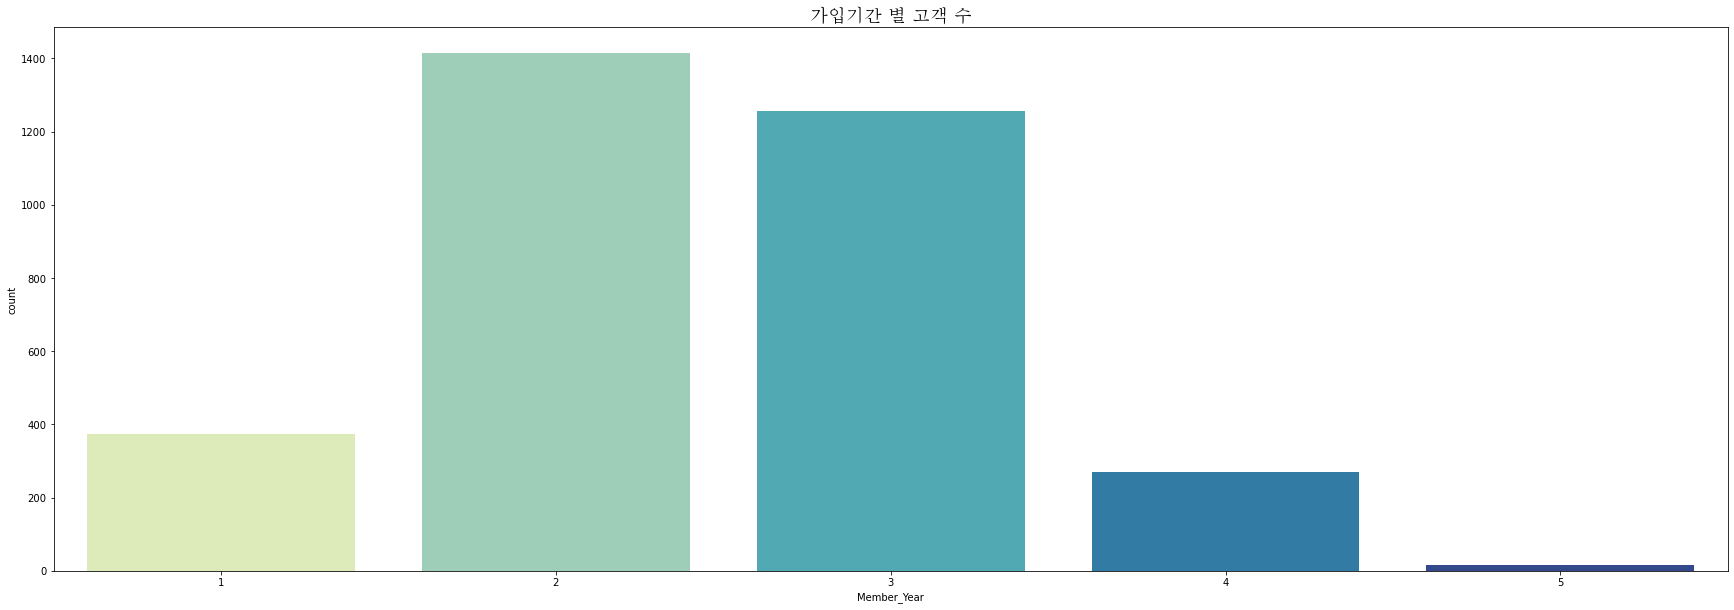

In [43]:
plt.rcParams['figure.figsize'] = (30, 10)
sns.countplot(telco.Member_Year, palette='YlGnBu')
#plt.xticks(rotation=45)
ax = plt.gca()
ax.set_title("가입기간 별 고객 수",fontproperties=fontprop)

## 연도별 분포도를 요금제 분포도를 조사해 보았습니다.
아래 그래프를 보니 모든 박스가 비슷한 위치에 비슷한 크기로 모여있습니다.  
딱히 몇년차 가입자가 요금을 더 많이내고 그런건 아닙니다.    
가입연도와 요금제는 관계가 적어보입니다.

In [44]:
g=sns.catplot(x='Member_Year',y='MonthlyFee',data=YearAndFee,kind='box')
sns.swarmplot(x='Member_Year',y='MonthlyFee',data=YearAndFee,color='k',size=1,ax=g.ax)

NameError: name 'YearAndFee' is not defined

# 3-2. 콜센터 전화 빈도수와 요금 관계
콜센터의 전화 빈도수와 요금도 크게 상관없는 것 같습니다.  
9회가 다소 높은 값을 보이긴하지만 매우 작은 숫자라 예외사항으로 보아도 좋을 것 같습니다.

C:\Users\rkdwn\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Callcenter', ylabel='MonthlyFee'>

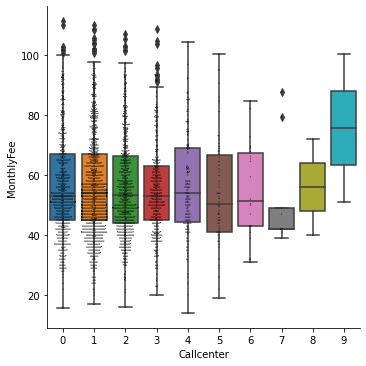

In [45]:
g=sns.catplot(x='Callcenter',y='MonthlyFee',data=telco,kind='box')
sns.swarmplot(x='Callcenter',y='MonthlyFee',data=telco,color='k',size=1,ax=g.ax)

# 3-3. 데이터 사용량과 요금 관계

In [46]:
telco["DataAmount_Category"]=0

데이터 사용량이 0~6G의 범위를 갖도록 하겟습니다.

In [47]:
telco['DataAmount'].describe()

count    3333.000000
mean        0.816895
std         1.273438
min         0.000000
25%         0.000000
50%         0.000000
75%         1.780273
max         5.398438
Name: DataAmount, dtype: float64

In [48]:
def DataAmount_Category(telco) :
    
    if telco["DataAmount"] == 0.0 :
        return 0
    elif (telco["DataAmount"] > 0) & (telco["DataAmount"] <= 1 ):
        return 1
    elif (telco["DataAmount"] > 1) & (telco["DataAmount"] <= 2) :
        return 2
    elif (telco["DataAmount"] > 2) & (telco["DataAmount"] <= 3) :
        return 3
    elif (telco["DataAmount"] > 3) & (telco["DataAmount"] <= 4) :
        return 4
    elif (telco["DataAmount"] > 4) & (telco["DataAmount"] <= 5) :
        return 5
    elif telco["DataAmount"] > 5 :
        return 6
telco["DataAmount_Category"] = telco.apply(lambda telco:DataAmount_Category(telco),
                                      axis = 1)
    

### 데이터를 많이 사용할 수록 요금을 많이 지불합니다.

C:\Users\rkdwn\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 31.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='DataAmount_Category', ylabel='MonthlyFee'>

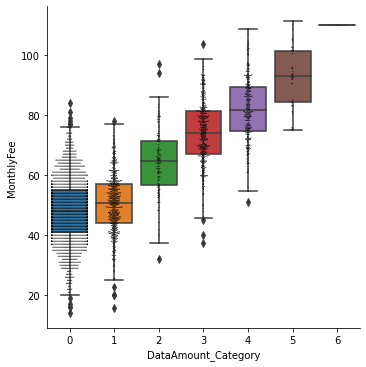

In [49]:
g=sns.catplot(x='DataAmount_Category',y='MonthlyFee',data=telco,kind='box')
sns.swarmplot(x='DataAmount_Category',y='MonthlyFee',data=telco,color='k',size=1,ax=g.ax)

# 3-4.전화 사용량과 요금 관계

In [50]:
telco["CalMins_Category"]=0

0~351의 범위를 갖습니다. 따라서 50분 단위로 범주화해 분석을 해보겠습니다.

In [51]:
telco['CalMins'].describe()

count    3333.000000
mean      179.775131
std        54.467442
min         0.000000
25%       143.699997
50%       179.399994
75%       216.399994
max       350.799988
Name: CalMins, dtype: float64

In [52]:
def CalMins_Category(telco) :
    
    if (telco["CalMins"] > 0) & (telco["CalMins"] <= 50 ):
        return 50
    elif (telco["CalMins"] > 50) & (telco["CalMins"] <= 100) :
        return 100
    elif (telco["CalMins"] > 100) & (telco["CalMins"] <= 150) :
        return 150
    elif (telco["CalMins"] > 150) & (telco["CalMins"] <= 200) :
        return 200
    elif (telco["CalMins"] > 200) & (telco["CalMins"] <= 250) :
        return 250
    elif (telco["CalMins"] > 250) & (telco["CalMins"] <= 300) :
        return 300
    elif telco["CalMins"] > 300 :
        return 350
telco["CalMins_Category"] = telco.apply(lambda telco:CalMins_Category(telco),
                                      axis = 1)
    

## 전화를 많이 사용할 수록 요금을 많이 지불하고 있습니다.

C:\Users\rkdwn\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 13.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\rkdwn\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='CalMins_Category', ylabel='MonthlyFee'>

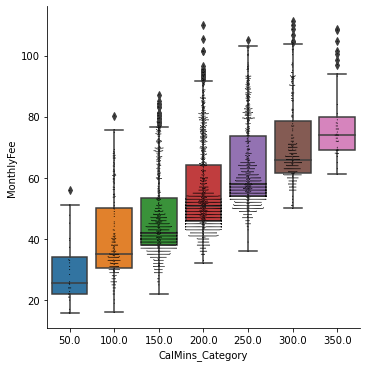

In [53]:
g=sns.catplot(x='CalMins_Category',y='MonthlyFee',data=telco,kind='box')
sns.swarmplot(x='CalMins_Category',y='MonthlyFee',data=telco,color='k',size=1,ax=g.ax)

# 3-5. 전화 횟수와 요금 관계

In [54]:
telco["CalCounts_Category"]=0

0~165회에 분포하고 있습니다. 30회 단위로 나누어 보겠습니다.

In [55]:
telco['CalCounts'].describe()

count    3333.000000
mean      100.435644
std        20.069084
min         0.000000
25%        87.000000
50%       101.000000
75%       114.000000
max       165.000000
Name: CalCounts, dtype: float64

In [56]:
def CalCounts_Category(telco) :
    
    if (telco["CalCounts"] > 0) & (telco["CalCounts"] <= 30 ):
        return 30
    elif (telco["CalCounts"] > 30) & (telco["CalCounts"] <= 60) :
        return 60
    elif (telco["CalCounts"] > 60) & (telco["CalCounts"] <= 90) :
        return 90
    elif (telco["CalCounts"] > 90) & (telco["CalCounts"] <= 120) :
        return 120
    elif (telco["CalCounts"] > 120) & (telco["CalCounts"] <= 150) :
        return 150
    elif telco["CalCounts"] > 150 :
        return 165
telco["CalCounts_Category"] = telco.apply(lambda telco:CalCounts_Category(telco),
                                      axis = 1)
    

## 전화 횟수와 요금은 상관이 없습니다. 

<AxesSubplot:xlabel='CalCounts_Category', ylabel='MonthlyFee'>

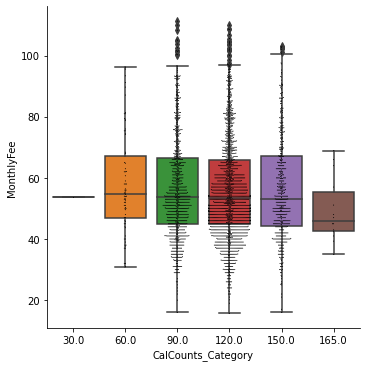

In [57]:
g=sns.catplot(x='CalCounts_Category',y='MonthlyFee',data=telco,kind='box')
sns.swarmplot(x='CalCounts_Category',y='MonthlyFee',data=telco,color='k',size=1,ax=g.ax)

# 3-6. 초과 요금과 요금 관계

In [58]:
telco["OverFee_Category"]=0

초과 요금의 경우 최소 0~19범위의 값을 가지고 있습니다.
초과요금 4달러 단위로 범주화 시켜보겠습니다.

In [59]:
telco['OverFee'].describe()

count    3333.000000
mean       10.054688
std         2.535156
min         0.000000
25%         8.328125
50%        10.070312
75%        11.773438
max        18.187500
Name: OverFee, dtype: float64

In [60]:
def OverFee_Category(telco) :
    
    if (telco["OverFee"] > 0) & (telco["OverFee"] <= 4 ):
        return 4
    elif (telco["OverFee"] > 4) & (telco["OverFee"] <= 8) :
        return 8
    elif (telco["OverFee"] > 8) & (telco["OverFee"] <= 12) :
        return 12
    elif (telco["OverFee"] > 12) & (telco["OverFee"] <= 16) :
        return 16 
    elif (telco["OverFee"] > 16): 
        return 20
telco["OverFee_Category"] = telco.apply(lambda telco:OverFee_Category(telco),
                                      axis = 1)
    

## 초과요금이 많을수록 월 요금이 다소 증가함을 알 수 있습니다.

<AxesSubplot:xlabel='OverFee_Category', ylabel='MonthlyFee'>

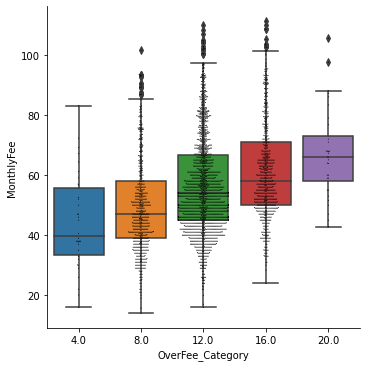

In [61]:
g=sns.catplot(x='OverFee_Category',y='MonthlyFee',data=telco,kind='box')
sns.swarmplot(x='OverFee_Category',y='MonthlyFee',data=telco,color='k',size=1,ax=g.ax)

# 3-7. 로밍시간과 요금 관계

In [62]:
telco["RoamingMin_Category"]=0

0~20분의 값을 가지고 있습니다. 4분을 단위로하여 범주를 나누어 보도록 하겠습니다.

In [63]:
telco['RoamingMin'].describe()

count    3333.000000
mean       10.234375
std         2.791016
min         0.000000
25%         8.500000
50%        10.296875
75%        12.101562
max        20.000000
Name: RoamingMin, dtype: float64

In [64]:
def RoamingMin_Category(telco) :
    
    if (telco["RoamingMin"] > 0) & (telco["RoamingMin"] <= 4 ):
        return 4
    elif (telco["RoamingMin"] > 4) & (telco["RoamingMin"] <= 8) :
        return 8
    elif (telco["RoamingMin"] > 8) & (telco["RoamingMin"] <= 12) :
        return 12
    elif (telco["RoamingMin"] > 12) & (telco["RoamingMin"] <= 16) :
        return 16 
    elif (telco["RoamingMin"] > 16): 
        return 20
telco["RoamingMin_Category"] = telco.apply(lambda telco:RoamingMin_Category(telco),
                                      axis = 1)
    

로밍시간 역시 조금은 월 요금과 상관이 있지만 큰 관계는 없어보입니다.

<AxesSubplot:xlabel='RoamingMin_Category', ylabel='MonthlyFee'>

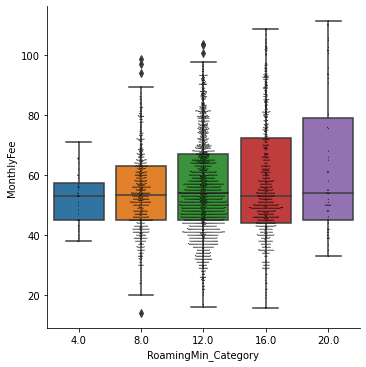

In [65]:
g=sns.catplot(x='RoamingMin_Category',y='MonthlyFee',data=telco,kind='box')
sns.swarmplot(x='RoamingMin_Category',y='MonthlyFee',data=telco,color='k',size=1,ax=g.ax)

# 4. 이탈안하며 가입갱신을 한 회원 분석

# 1. 전체 고객 중 가입 해지 유무 별 월 요금 분석
약 **63 달러** 이상에서 좀더 많이 해지했음을 알 수 있습니다.

Text(0.5, 1.0, 'Current Member VS Out of Member')

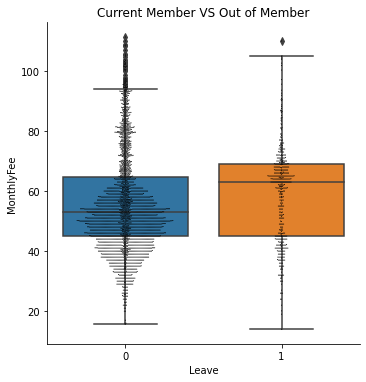

In [66]:
g=sns.catplot(x='Leave',y='MonthlyFee',data=telco,kind='box')
sns.swarmplot(x='Leave',y='MonthlyFee',data=telco,color='k',size=1,ax=g.ax)
plt.title("Current Member VS Out of Member")

## 또한 현재 고객 중에서 새 갱신한 고객은 월 요금이 낮은 경향으로 보이고 있습니다.

Text(0.5, 1.0, 'No Contract VS New Contract')

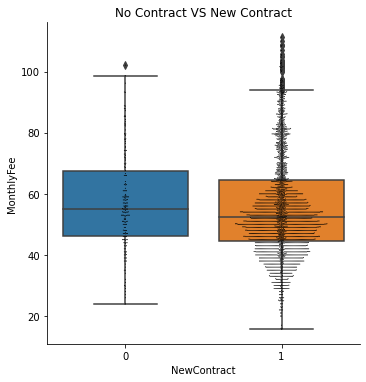

In [67]:
g=sns.catplot(x='NewContract',y='MonthlyFee',data=Current_Member,kind='box')
sns.swarmplot(x='NewContract',y='MonthlyFee',data=Current_Member,color='k',size=1,ax=g.ax)
plt.title("No Contract VS New Contract")

# 5. 이탈률 예측 딥러닝 모델 만들기

In [68]:
import tensorflow as tf

**정답 데이터인 Y**에는 이탈 Category를 넣습니다.

In [69]:
yData=telco['Leave'].values 
print(yData)

[0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0]
Length: 3333
Categories (2, int64): [0, 1]


**x 데이터**에는 가입기간, 갱신여부, 데이터 사용유무, 데이터 사용량, 고객센터 전화 횟수, 전화시간, 전화 횟수, 월 요금, 초과요금, 로밍 요금 모두를 넣어주었습니다.

In [70]:
xData=[]
for i,rows in telco.iterrows():
    xData.append([rows['MemberWeeks'],rows['NewContract'],rows['IsData'],rows['DataAmount'],rows['Callcenter'],rows['CalMins'],rows['CalCounts'],rows['MonthlyFee'],rows['OverFee'],rows['RoamingMin']])

여기서 **Sequential**을 쓰면 신경망 레이어들을 쉽게 만들 수 있습니다.  

각각의 레이어의 **64**와 **128**, 활성함수는 **tanh**를 넣었습니다. 마지막 노드에는 활성함수로 **sigmoid**를 넣었습니다.  
컴파일 할땐 **Optimizer**에는 **Adam**을, **Loss에는 Binary crossentropy**, **Metrics**에는 **Accuracy**를 넣어줍니다.  
x엔 학습데이터를 y엔 정답을 넣어주고 **Epoch**는 **1000회**를 넣었습니다.  

In [71]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(64,activation='tanh'),
    tf.keras.layers.Dense(128,activation='tanh'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.fit(np.array(xData),np.array(yData),epochs=1000)

Epoch 1/1000
105/105 [==============================] - 1s 1ms/step - loss: 0.4259 - accuracy: 0.8519
Epoch 2/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.4276 - accuracy: 0.8508
Epoch 3/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.4082 - accuracy: 0.8493
Epoch 4/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.3910 - accuracy: 0.8593
Epoch 5/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.4083 - accuracy: 0.8495
Epoch 6/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.3965 - accuracy: 0.8555
Epoch 7/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.3887 - accuracy: 0.8560
Epoch 8/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.3836 - accuracy: 0.8628
Epoch 9/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.3867 - accuracy: 0.8538
Epoch 10/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.375

105/105 [==============================] - 0s 1ms/step - loss: 0.2832 - accuracy: 0.8765
Epoch 81/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2588 - accuracy: 0.8832
Epoch 82/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2529 - accuracy: 0.8956
Epoch 83/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2675 - accuracy: 0.8909
Epoch 84/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2491 - accuracy: 0.8949
Epoch 85/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2465 - accuracy: 0.8980
Epoch 86/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2425 - accuracy: 0.8979
Epoch 87/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2644 - accuracy: 0.8957
Epoch 88/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2666 - accuracy: 0.8898
Epoch 89/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2595 - a

105/105 [==============================] - 0s 1ms/step - loss: 0.2513 - accuracy: 0.8910
Epoch 159/1000
105/105 [==============================] - 0s 952us/step - loss: 0.2218 - accuracy: 0.9057
Epoch 160/1000
105/105 [==============================] - 0s 943us/step - loss: 0.2387 - accuracy: 0.9004
Epoch 161/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2253 - accuracy: 0.9145
Epoch 162/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2454 - accuracy: 0.8984
Epoch 163/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2290 - accuracy: 0.8998
Epoch 164/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2295 - accuracy: 0.9044
Epoch 165/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2257 - accuracy: 0.9066
Epoch 166/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2315 - accuracy: 0.9027
Epoch 167/1000
105/105 [==============================] - 0s 1ms/step - los

105/105 [==============================] - 0s 1ms/step - loss: 0.2232 - accuracy: 0.9128
Epoch 237/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2189 - accuracy: 0.9159
Epoch 238/1000
105/105 [==============================] - 0s 991us/step - loss: 0.2061 - accuracy: 0.9169
Epoch 239/1000
105/105 [==============================] - 0s 991us/step - loss: 0.2025 - accuracy: 0.9200
Epoch 240/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2059 - accuracy: 0.9177
Epoch 241/1000
105/105 [==============================] - 0s 991us/step - loss: 0.2222 - accuracy: 0.9100
Epoch 242/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2044 - accuracy: 0.9207
Epoch 243/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2131 - accuracy: 0.9101
Epoch 244/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2273 - accuracy: 0.9035
Epoch 245/1000
105/105 [==============================] - 0s 1ms/step - l

105/105 [==============================] - 0s 1ms/step - loss: 0.2106 - accuracy: 0.9100
Epoch 315/1000
105/105 [==============================] - 0s 952us/step - loss: 0.2195 - accuracy: 0.9100
Epoch 316/1000
105/105 [==============================] - 0s 991us/step - loss: 0.1970 - accuracy: 0.9158
Epoch 317/1000
105/105 [==============================] - 0s 981us/step - loss: 0.2082 - accuracy: 0.9121
Epoch 318/1000
105/105 [==============================] - 0s 943us/step - loss: 0.2068 - accuracy: 0.9098
Epoch 319/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2116 - accuracy: 0.9090
Epoch 320/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2006 - accuracy: 0.9220
Epoch 321/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2350 - accuracy: 0.9025
Epoch 322/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2062 - accuracy: 0.9123
Epoch 323/1000
105/105 [==============================] - 0s 1ms/step -

105/105 [==============================] - 0s 1ms/step - loss: 0.1818 - accuracy: 0.9247
Epoch 393/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1969 - accuracy: 0.9186
Epoch 394/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1749 - accuracy: 0.9267
Epoch 395/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1990 - accuracy: 0.9157
Epoch 396/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1829 - accuracy: 0.9305
Epoch 397/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1649 - accuracy: 0.9336
Epoch 398/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1824 - accuracy: 0.9325
Epoch 399/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1939 - accuracy: 0.9247
Epoch 400/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1718 - accuracy: 0.9364
Epoch 401/1000
105/105 [==============================] - 0s 1ms/step - loss: 0

105/105 [==============================] - 0s 1ms/step - loss: 0.1719 - accuracy: 0.9338
Epoch 471/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1843 - accuracy: 0.9226
Epoch 472/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1748 - accuracy: 0.9238
Epoch 473/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1773 - accuracy: 0.9283
Epoch 474/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1898 - accuracy: 0.9257
Epoch 475/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1715 - accuracy: 0.9306
Epoch 476/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1740 - accuracy: 0.9282
Epoch 477/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1733 - accuracy: 0.9303
Epoch 478/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1743 - accuracy: 0.9340
Epoch 479/1000
105/105 [==============================] - 0s 1ms/step - loss: 0

Epoch 548/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1500 - accuracy: 0.9371
Epoch 549/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1667 - accuracy: 0.9330
Epoch 550/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1827 - accuracy: 0.9269
Epoch 551/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1556 - accuracy: 0.9342
Epoch 552/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1723 - accuracy: 0.9302
Epoch 553/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1885 - accuracy: 0.9221
Epoch 554/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1572 - accuracy: 0.9400
Epoch 555/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1812 - accuracy: 0.9262
Epoch 556/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1552 - accuracy: 0.9384
Epoch 557/1000
105/105 [==============================] - 0s 1ms

105/105 [==============================] - 0s 1ms/step - loss: 0.1662 - accuracy: 0.9336
Epoch 627/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1482 - accuracy: 0.9388
Epoch 628/1000
105/105 [==============================] - 0s 981us/step - loss: 0.1533 - accuracy: 0.9392
Epoch 629/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1778 - accuracy: 0.9271
Epoch 630/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1704 - accuracy: 0.9348
Epoch 631/1000
105/105 [==============================] - 0s 991us/step - loss: 0.1622 - accuracy: 0.9348
Epoch 632/1000
105/105 [==============================] - 0s 991us/step - loss: 0.1591 - accuracy: 0.9366
Epoch 633/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1440 - accuracy: 0.9428
Epoch 634/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1536 - accuracy: 0.9362
Epoch 635/1000
105/105 [==============================] - 0s 1ms/step - l

105/105 [==============================] - 0s 1ms/step - loss: 0.1640 - accuracy: 0.9327
Epoch 705/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1522 - accuracy: 0.9388
Epoch 706/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1458 - accuracy: 0.9456
Epoch 707/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1420 - accuracy: 0.9388
Epoch 708/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1466 - accuracy: 0.9413
Epoch 709/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1469 - accuracy: 0.9410
Epoch 710/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1413 - accuracy: 0.9386
Epoch 711/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1424 - accuracy: 0.9341
Epoch 712/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1481 - accuracy: 0.9405
Epoch 713/1000
105/105 [==============================] - 0s 1ms/step - loss: 0

105/105 [==============================] - 0s 991us/step - loss: 0.1234 - accuracy: 0.9474
Epoch 783/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1656 - accuracy: 0.9325
Epoch 784/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1355 - accuracy: 0.9451
Epoch 785/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1384 - accuracy: 0.9397
Epoch 786/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1443 - accuracy: 0.9386
Epoch 787/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2424 - accuracy: 0.9003
Epoch 788/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1623 - accuracy: 0.9285
Epoch 789/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1457 - accuracy: 0.9377
Epoch 790/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1166 - accuracy: 0.9552
Epoch 791/1000
105/105 [==============================] - 0s 1ms/step - loss:

105/105 [==============================] - 0s 1ms/step - loss: 0.1331 - accuracy: 0.9403
Epoch 861/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1308 - accuracy: 0.9430
Epoch 862/1000
105/105 [==============================] - 0s 981us/step - loss: 0.1355 - accuracy: 0.9423
Epoch 863/1000
105/105 [==============================] - 0s 991us/step - loss: 0.1385 - accuracy: 0.9412
Epoch 864/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1210 - accuracy: 0.9474
Epoch 865/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.1425 - accuracy: 0.9406
Epoch 866/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1385 - accuracy: 0.9366
Epoch 867/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1567 - accuracy: 0.9340
Epoch 868/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1195 - accuracy: 0.9568
Epoch 869/1000
105/105 [==============================] - 0s 1ms/step - los

105/105 [==============================] - 0s 1ms/step - loss: 0.1242 - accuracy: 0.9491
Epoch 939/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1470 - accuracy: 0.9373
Epoch 940/1000
105/105 [==============================] - 0s 952us/step - loss: 0.1171 - accuracy: 0.9507
Epoch 941/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1116 - accuracy: 0.9508
Epoch 942/1000
105/105 [==============================] - 0s 981us/step - loss: 0.1162 - accuracy: 0.9450
Epoch 943/1000
105/105 [==============================] - 0s 991us/step - loss: 0.1522 - accuracy: 0.9282
Epoch 944/1000
105/105 [==============================] - 0s 991us/step - loss: 0.1452 - accuracy: 0.9438
Epoch 945/1000
105/105 [==============================] - 0s 991us/step - loss: 0.1190 - accuracy: 0.9582
Epoch 946/1000
105/105 [==============================] - 0s 981us/step - loss: 0.1282 - accuracy: 0.9473
Epoch 947/1000
105/105 [==============================] - 0s 1ms/st

#### 고객 정보 입력받기

In [73]:
MemberWeek = int(input('1.가입 기간을 입력하세요 (주 단위): '))
NewConstract = int(input('2.신규 갱신 여부를 입력하세요. 갱신은 1, 아니면 0 입력 '))
IsData = int(input('3.데이터 사용 여부를 입력하세요 (사용은 1, 아니면 0): '))
DataAmount = int(input('4.데이터 사용량을 반올림해서 입력하세요. (소수점 첫째 자리에서 반올림) (단위 G): '))
Callcenter = int(input('5.콜센터에 전화 횟수를 입력하세요: '))
CalMins = int(input('6.전화한 시간을 입력하세요. (소수점 첫재 짜리에서 반올림) (단위 : 분): '))
CalCounts = int(input('7.전화 횟수를 입력하세요: '))
MonthlyFee = int(input('8.한달 요금을 입력하세요. 소수점 첫째 자리에서 반올림: '))
OverFee = int(input('9.초과요금을 입력하세요 (소수점 첫째 자리에서 반올림): '))
RoamingMin = int(input('10로밍 요금을 입력하세요: '))

1.가입 기간을 입력하세요 (주 단위): 77
2.신규 갱신 여부를 입력하세요. 갱신은 1, 아니면 0 입력 1
3.데이터 사용 여부를 입력하세요 (사용은 1, 아니면 0): 0
4.데이터 사용량을 반올림해서 입력하세요. (소수점 첫째 자리에서 반올림) (단위 G): 0
5.콜센터에 전화 횟수를 입력하세요: 5
6.전화한 시간을 입력하세요. (소수점 첫재 짜리에서 반올림) (단위 : 분): 63
7.전화 횟수를 입력하세요: 89
8.한달 요금을 입력하세요. 소수점 첫째 자리에서 반올림: 26
9.초과요금을 입력하세요 (소수점 첫째 자리에서 반올림): 9
10로밍 요금을 입력하세요: 6


In [74]:
predict =model.predict([[MemberWeek,NewConstract,IsData,DataAmount,Callcenter,CalMins,CalCounts,MonthlyFee,OverFee,RoamingMin]])
print(predict)

[[0.9999399]]


In [75]:
predict=predict*100

#### 도출한 확률값을 이용한 함수 생성

In [76]:
def Result(predict) :   
    if (predict > 0.0) & (predict <= 20) :
        return print("이탈지수 :",predict,", 장기 멤버으로 예측된 고객입니다. 안전합니다.")
    elif (predict > 20) & (predict <= 40) :
        return print("이탈지수 :",predict,", 장기 멤버 가능성이 있는 고객입니다.")
    elif (predict > 40) & (predict <= 60) :
        return print("이탈지수 :",predict,", 이탈 징후가 보이기 시작했습니다.")
    elif (predict > 60) & (predict <= 80) :
        return print("이탈지수 :",predict,", 이탈 가능성이 있는 고객입니다. 지켜보세요")
    elif (predict > 80) & (predict <= 100) :
        return print("이탈지수 :",predict,", 곧 이탈할 고객입니다. 주의하세요") 

# 현재 고객의 이탈 예측 값 도출

In [77]:
Result(predict)

이탈지수 : [[99.99399]] , 곧 이탈할 고객입니다. 주의하세요


# 결론과 가이드 제시


**1.** 전화 시간과 데이터 사용량은 월 요금과 큰 관계가 높은 반면,  
가입기간, 콜센터 전화수, 전화횟수와는 관계가 없다.  
초과 요금과 로밍시간은 월 요금과 아주 약간의 관계가 있으나 미약하다.  

-> 고객이 전화를 오래하고 데이터를 많이 쓰도록 해야한다.

-> 데이터 가입하지 않은 사람에게는 **가입을 하도록 유도**하고
**통화를 오래**하도록 해야한다.

->  초과요금과 로밍요금은 월 요금제와 큰 차이가 없으니 서비스로 제공하는 정도는 고려하되  
데이터와 전화요금을 올리는 서비스도 좋을 것 같다.

**2.** 초반의 요금을 많이내는 사람에게 초과 요금과 로밍요금같은 효과미미한 서비스를 무료로 제공해주면서  맴버쉽 기간을 늘려야할 것이다.  
특히 위 데이터 분석에서 **2년차 이후 감소하는 경향**이 있으므로 2년차 때 고객을 잘 케어해야한다.

**3.** 요금을 적게내면서 고객센터에 전화를 많이하는 사람을 **블랙리스트**로 관리했다.  
위 블랙리스트 들에게 해지를 유도하는 것이 회사 이익의 좋은 방향일 수 있다.

하지만 위 분석결과 **약 63$ 부근에서 해지하는 경향**을 보여주었다.   
-> 비싼요금을 낼 수록 이탈률이 증가하므로 **Trade Off 관계** 를 잘 고려해야 한다.


# 어려웠던 점


데이터가 국내인지 외국인지 알수없었고, 외국데이터라면 그 나라의 문화 등을 고려해야 할텐데 그 점을 고려하지 못했다.  
따라서 어떠한 좋은 서비스를 제공해 수 있을지 난해한 점이 있었다.

# 마무리 하며..
#### 데이터 분석하기전 결과 예측을 아래와 같이 하였었습니다.
 1. 상위 25%고객은 월요금제에 둔감하여 고객센터에 전화를 잘 안할것이다.
 2. 상위 25%고객이 월 매출의 절반이상을 차지할 것이다.
 3. 다른것에 비해 데이터를 많이 사용할수록 월요금이 증가할 것이다.

예상대로 데이터를 많이 사용할수록 월 요금이 증가하하기도 했지만    
오히려 상위 고객이 고객센터에 전화를 좀 더 하였고, 매출도 지배할정도로 차지하진 않았습니다.    

추가로 분석하다보니 예상치못하게 호기심이 생겨서 더 분석해 좋은 결과를 도출하기도 했습니다.     
ex) 딥러닝 모델을 활용해 고객 이탈 확률 예측  
 
수업시간에 배운 내용을 토대로 데이터 전처리부터 분석, 시각화 등을 활용할 수 있던 좋은 기회였습니다.  

한학기 알찬 강의 덕분에 많은 것을 배웠습니다. 한학기 정말 수고많으셨습니다.   
감사합니다.  

강준구 올림. 2021.06.16
